# Semi-Supervised Learning & Self-Supervised Learning

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets
import torch.nn.functional as F
from tqdm import tqdm

import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
import torchvision
import transformers

/home/cglee/anaconda3/envs/ahnlab/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [2]:
class RandomFlip(object):
    """Flip randomly the image.
    """
    def __call__(self, x):
        if np.random.rand() < 0.5:
            x = x[:, :, ::-1]

        return x.copy()
    
def pad(x, border=4):
    return np.pad(x, [(0, 0), (border, border), (border, border)], mode='reflect')

class RandomPadandCrop(object):
    """Crop randomly the image.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, x):
        # x : [32, 32, 3] -> [3, 32, 32]
        x = np.transpose(x, (2, 0, 1))
        x = pad(x, 4)

        h, w = x.shape[1:]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        x = x[:, top: top + new_h, left: left + new_w]
        
        # x : [3, 32, 32] -> [32, 32, 3]
        x = np.transpose(x, (1, 2, 0))

        return x
    
import os
import shutil

# Hyperparameters
BATCH_SIZE = 32
LAMBDA_U = 75
TRAIN_ITERATION = 1024 # change this
T = 0.5
ALPHA = 0.75
LR = 0.002
EMA_DECAY = 0.999
EPOCHS = 480 # change this


# Feel free to incorporate additional transforms, such as data augmentation.
train_transform = transforms.Compose( # Strong Augmentation
    [
        RandomPadandCrop(32),
        RandomFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4913, 0.4821, 0.4465), (0.247, 0.2434, 0.2615))
        ]
    )

valid_transform = transforms.Compose( # No Augmentation
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4913, 0.4821, 0.4465), (0.247, 0.2434, 0.2615))
        ]
    )

## **Do not modify the cell below!!!!**


In [3]:
train_dataset = datasets.CIFAR10(root="./data/",
                                 train=True,
                                 download=True,
                                transform=train_transform
                                 )

val_dataset = datasets.CIFAR10(root="./data/",
                                train=False,
                                download=True,
                                 transform=valid_transform
                                )

num_labeled = 5000
num_unlabeled = len(train_dataset) - num_labeled

indices = list(range(len(train_dataset)))
labeled_indices = indices[:num_labeled]
unlabeled_indices = indices[num_labeled:]

for idx in unlabeled_indices:
    train_dataset.targets[idx] = -1

labeled_train_dataset = torch.utils.data.Subset(train_dataset, labeled_indices)
unlabeled_train_dataset = torch.utils.data.Subset(train_dataset, unlabeled_indices)

labeled_train_loader = torch.utils.data.DataLoader(dataset=labeled_train_dataset,
                                             batch_size=BATCH_SIZE,
                                             drop_last=True,
                                             shuffle=True)

unlabeled_train_loader = torch.utils.data.DataLoader(dataset=unlabeled_train_dataset,
                                             batch_size=BATCH_SIZE,
                                             drop_last=True,
                                             shuffle=False)
unlabeled_train_loader2 = torch.utils.data.DataLoader(dataset=unlabeled_train_dataset,
                                             batch_size=BATCH_SIZE,
                                             drop_last=True,
                                             shuffle=False)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class val_Dataset2(Dataset):
    def __init__(self,img_file, label_file, transform=None):
        self.img =np.load(img_file)
        self.labels = np.load(label_file)
        self.transform = transform

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        image = self.img[idx]
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]

        return image,label

In [5]:
val_dataset2 = val_Dataset2(img_file="./valid_dataset2.npy",label_file="./valid_dataset2_label.npy",transform=valid_transform)
val_loader2 = torch.utils.data.DataLoader(val_dataset2, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [6]:
next(iter(val_loader2))

[tensor([[[[-1.8779e+00, -1.6557e+00, -1.7033e+00,  ..., -1.6557e+00,
            -1.4175e+00, -1.2270e+00],
           [-1.4651e+00, -1.6398e+00, -1.7350e+00,  ..., -1.7509e+00,
            -1.4016e+00, -1.1794e+00],
           [-3.5376e-01, -1.2905e+00, -1.7668e+00,  ..., -1.8303e+00,
            -1.3699e+00, -1.0682e+00],
           ...,
           [-1.3540e+00, -1.7192e+00, -1.7192e+00,  ..., -1.6239e+00,
            -1.5604e+00, -1.4334e+00],
           [-1.2111e+00, -1.7033e+00, -1.7668e+00,  ..., -1.5763e+00,
            -1.5445e+00, -1.4651e+00],
           [-7.6656e-01, -1.5445e+00, -1.7668e+00,  ..., -1.4651e+00,
            -1.4810e+00, -1.4969e+00]],
 
          [[-1.7551e+00, -1.7229e+00, -1.7874e+00,  ..., -1.6423e+00,
            -1.4168e+00, -1.1751e+00],
           [-1.4973e+00, -1.6585e+00, -1.8518e+00,  ..., -1.7390e+00,
            -1.4007e+00, -1.1429e+00],
           [-4.0175e-01, -1.2879e+00, -1.8679e+00,  ..., -1.8196e+00,
            -1.3684e+00, -1.0462e+00],


In [7]:
print("labeled_train_dataset size : ", len(labeled_train_dataset))
print("unlabeled_train_dataset size : ", len(unlabeled_train_dataset))
print("val_dataset size : ", len(val_dataset))
print("val_dataset2 size : ", len(val_dataset2))

labeled_train_dataset size :  5000
unlabeled_train_dataset size :  45000
val_dataset size :  10000
val_dataset2 size :  9500


/tmp/ipykernel_1945373/3088434795.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  plt.imshow(labeled_train_dataset[0][0].T)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


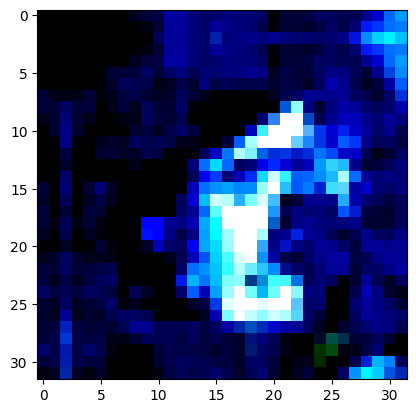

In [8]:
plt.imshow(labeled_train_dataset[0][0].T)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


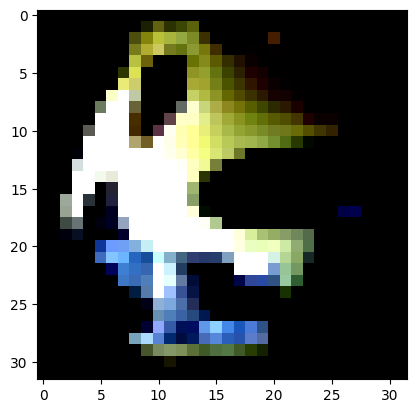

In [9]:
plt.imshow(val_dataset2[0][0].T)

In [10]:
temp = [0]*10
for i in range(5000):
  temp[labeled_train_dataset[i][-1]] = temp[labeled_train_dataset[i][-1]] + 1

In [11]:
temp

[505, 460, 519, 486, 519, 488, 519, 486, 520, 498]

# Define Model, Loss Function and Optimizer

Here we define the model, loss function, optimizer and optionally a learning rate scheduler. Below is very simple model with CNN. You can customize your own model and note that you are not limited to use any methods. **But you are not allowed to use pretrained weight**

#### 1) Semi-Supervised Learning with MixMatch

In [12]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0, activate_before_residual=False):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes, momentum=0.001)
        self.relu1 = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes, momentum=0.001)
        self.relu2 = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None
        self.activate_before_residual = activate_before_residual
    def forward(self, x):
        if not self.equalInOut and self.activate_before_residual == True:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0, activate_before_residual=False):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate, activate_before_residual)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate, activate_before_residual):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate, activate_before_residual))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class WideResNet(nn.Module):
    def __init__(self, num_classes, depth=28, widen_factor=2, dropRate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate, activate_before_residual=True)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3], momentum=0.001)
        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.zero_()

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        return self.fc(out)

def create_model(device, ema=False):
    model = WideResNet(10, 28, 2, 0.3)
    model = model.to(device)

    if ema:
        for param in model.parameters():
            param.detach_()

    return model

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [14]:
# Utils
import math

def save_checkpoint(state, is_best, checkpoint=".", filename='checkpoint.pth.tar'):
    acc = state['acc']
    epoch = state['epoch']
    filename = 'F_epoch{}_acc{:.2f}.pth.tar'.format(epoch, acc)
    filepath = os.path.join(checkpoint, filename)
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(checkpoint, 'model_best.pth.tar'))

def linear_rampup(current, rampup_length=EPOCHS):
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current / rampup_length, 0.0, 1.0)
        return float(current)

def interleave_offsets(batch, nu):
    groups = [batch // (nu + 1)] * (nu + 1)
    for x in range(batch - sum(groups)):
        groups[-x - 1] += 1
    offsets = [0]
    for g in groups:
        offsets.append(offsets[-1] + g)
    assert offsets[-1] == batch
    return offsets


def interleave(xy, batch):
    nu = len(xy) - 1
    offsets = interleave_offsets(batch, nu)
    xy = [[v[offsets[p]:offsets[p + 1]] for p in range(nu + 1)] for v in xy]
    for i in range(1, nu + 1):
        xy[0][i], xy[i][i] = xy[i][i], xy[0][i]
    return [torch.cat(v, dim=0) for v in xy]

class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

class SemiLoss(object):
    def __call__(self, outputs_x, targets_x, outputs_u, targets_u, epoch):
        probs_u = torch.softmax(outputs_u, dim=1)

        Lx = -torch.mean(torch.sum(F.log_softmax(outputs_x, dim=1) * targets_x, dim=1))
        Lu = torch.mean((probs_u - targets_u)**2)

        return Lx, Lu, LAMBDA_U * linear_rampup(epoch)
    
class WeightEMA(object):
    def __init__(self, model, ema_model, alpha=0.999):
        self.model = model
        self.ema_model = ema_model
        self.alpha = alpha
        self.params = list(model.state_dict().values())
        self.ema_params = list(ema_model.state_dict().values())
        self.wd = 0.02 * LR

        for param, ema_param in zip(self.params, self.ema_params):
            param.data.copy_(ema_param.data)

    def step(self):
        one_minus_alpha = 1.0 - self.alpha
        for param, ema_param in zip(self.params, self.ema_params):
            if ema_param.dtype==torch.float32:
                ema_param.mul_(self.alpha)
                ema_param.add_(param * one_minus_alpha)
                # customized weight decay
                param.mul_(1 - self.wd)

In [15]:
import time

def train(labeled_trainloader, unlabeled_trainloader, unlabeled_train_loader2,model, optimizer, ema_optimizer, criterion, epoch, use_cuda):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    losses_x = AverageMeter()
    losses_u = AverageMeter()
    ws = AverageMeter()

    labeled_train_iter = iter(labeled_trainloader)
    unlabeled_train_iter = iter(unlabeled_trainloader)
    unlabeled_train_iter2 = iter(unlabeled_train_loader2)

    model.train()
    for batch_idx in range(TRAIN_ITERATION):
        try:
            inputs_x, targets_x = next(labeled_train_iter)
        except:
            labeled_train_iter = iter(labeled_trainloader)
            inputs_x, targets_x = next(labeled_train_iter)

        try:
            (inputs_u), _ = next(unlabeled_train_iter)
            (inputs_u2), _ = next(unlabeled_train_iter2)
        except:
            unlabeled_train_iter = iter(unlabeled_trainloader)
            unlabeled_train_iter2 = iter(unlabeled_train_loader2)
            (inputs_u), _ = next(unlabeled_train_iter)
            (inputs_u2), _ = next(unlabeled_train_iter2)

        batch_size = inputs_x.size(0)

        # Transform label to one-hot
        targets_x = torch.zeros(batch_size, 10).scatter_(1, targets_x.view(-1,1).long(), 1)

        if use_cuda:
            inputs_x, targets_x = inputs_x.cuda(), targets_x.cuda(non_blocking=True)
            inputs_u = inputs_u.cuda()
            inputs_u2 = inputs_u2.cuda()

        with torch.no_grad():
            # compute guessed labels of unlabel samples
            outputs_u = model(inputs_u)
            outputs_u2 = model(inputs_u2)
            p = (torch.softmax(outputs_u, dim=1) + torch.softmax(outputs_u2, dim=1)) / 2
            pt = p**(1/T)
            targets_u = pt / pt.sum(dim=1, keepdim=True)
            targets_u = targets_u.detach()

        # mixup
        all_inputs = torch.cat([inputs_x, inputs_u, inputs_u2], dim=0)
        all_targets = torch.cat([targets_x, targets_u, targets_u], dim=0)

        l = np.random.beta(ALPHA, ALPHA)

        l = max(l, 1-l)

        idx = torch.randperm(all_inputs.size(0))

        input_a, input_b = all_inputs, all_inputs[idx]
        target_a, target_b = all_targets, all_targets[idx]

        mixed_input = l * input_a + (1 - l) * input_b
        mixed_target = l * target_a + (1 - l) * target_b

        # interleave labeled and unlabed samples between batches to get correct batchnorm calculation 
        mixed_input = list(torch.split(mixed_input, batch_size))
        mixed_input = interleave(mixed_input, batch_size)

        logits = [model(mixed_input[0])]
        for input in mixed_input[1:]:
            logits.append(model(input))

        # put interleaved samples back
        logits = interleave(logits, batch_size)
        logits_x = logits[0]
        logits_u = torch.cat(logits[1:], dim=0)

        Lx, Lu, w = criterion(logits_x, mixed_target[:batch_size], logits_u, mixed_target[batch_size:], epoch+batch_idx/TRAIN_ITERATION)

        loss = Lx + w * Lu

        # record loss
        losses.update(loss.item(), inputs_x.size(0))
        losses_x.update(Lx.item(), inputs_x.size(0))
        losses_u.update(Lu.item(), inputs_x.size(0))
        ws.update(w, inputs_x.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ema_optimizer.step()

    return (losses.avg, losses_x.avg, losses_u.avg,)

#### 2) Self-Supervised Learning using SimCLR

In [16]:
# simpleCLR 모델 정의
class SimCLR(nn.Module):
    def __init__(self, base_encoder, projection_dim=128):
        super().__init__()
        self.enc = base_encoder(pretrained=False)  # load model from torchvision.models without pretrained weights.
        self.feature_dim = self.enc.fc.in_features

        # Customize for CIFAR10. Replace conv 7x7 with conv 3x3, and remove first max pooling.
        self.enc.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.enc.maxpool = nn.Identity()
        self.enc.fc = nn.Identity()  # remove final fully connected layer.

        # Add MLP projection.
        self.projection_dim = projection_dim
        self.projector = nn.Sequential(nn.Linear(self.feature_dim, 2048),
                                       nn.ReLU(),
                                       nn.Linear(2048, projection_dim))

    def forward(self, x):
        feature = self.enc(x)
        projection = self.projector(feature)
        return feature, projection

class AverageMeter_self(object):
    """Computes and stores the average and current value"""
    def __init__(self, name):
        self.name = name
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def nt_xent(x, t=0.5):
    x = F.normalize(x, dim=1)
    x_scores =  (x @ x.t()).clamp(min=1e-7)  # normalized cosine similarity scores
    x_scale = x_scores / t   # scale with temperature

    # (2N-1)-way softmax without the score of i-th entry itself.
    # Set the diagonals to be large negative values, which become zeros after softmax.
    x_scale = x_scale - torch.eye(x_scale.size(0)).to(x_scale.device) * 1e5

    # targets 2N elements.
    targets = torch.arange(x.size()[0])
    targets[::2] += 1  # target of 2k element is 2k+1
    targets[1::2] -= 1  # target of 2k+1 element is 2k
    return F.cross_entropy(x_scale, targets.long().to(x_scale.device))

def get_lr(step, total_steps, lr_max, lr_min):
    """Compute learning rate according to cosine annealing schedule."""
    return lr_min + (lr_max - lr_min) * 0.5 * (1 + np.cos(step / total_steps * np.pi))

def train_pretext() -> None:
    assert torch.cuda.is_available()

    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.RandomRotation(degrees=45),  # Randomly rotate the image by a maximum of 15 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )


    train_loader = torch.utils.data.DataLoader(dataset=unlabeled_train_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True)

    # Prepare model
    base_encoder = torchvision.models.resnet18
    model = SimCLR(base_encoder, projection_dim=128).cuda()

    try:
        model.load_state_dict((torch.load('simclr_resnet18_epoch{}.pt'.format(20))))
        print("Pre-trained weights loaded successfully.")
    except FileNotFoundError:
        print("No pre-trained weights found. Training from scratch.")

    optimizer = torch.optim.SGD(
        model.parameters(),
        0.3 * BATCH_SIZE / 256,
        momentum=0.9,
        weight_decay=1.0e-6,
        nesterov=True)

    # cosine annealing lr
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=100 * len(train_loader),
        eta_min=1e-3)

    # SimCLR training
    model.train()




    ### Change this
    for epoch in range(1, 480 + 1): 
        loss_meter = AverageMeter_self("SimCLR_loss")
        train_bar = tqdm(train_loader)
        for x, y in train_bar:
            x = x.cuda(non_blocking=True)

            # Positive pairs: concatenate augmented versions
            x_augmented = torch.cat([x, x], dim=0)

            optimizer.zero_grad()
            feature, rep = model(x_augmented)
            loss = nt_xent(rep, 0.5)
            loss.backward()
            optimizer.step()
            scheduler.step()

            loss_meter.update(loss.item(), x.size(0))
            train_bar.set_description("Train epoch {}, SimCLR loss: {:.4f}".format(epoch, loss_meter.avg))

        # save checkpoint very log_interval epochs
        if epoch >= 10 and epoch % 10 == 0:
            torch.save(model.state_dict(), f'simclr_resnet18_epoch{epoch}.pt')

train_pretext()

/home/cglee/anaconda3/envs/ahnlab/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cglee/anaconda3/envs/ahnlab/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Pre-trained weights loaded successfully.


Train epoch 480, SimCLR loss: 4.1429: 100%|█████████████████████████████████████████████████████████████████| 1407/1407 [00:40<00:00, 34.52it/s]


# Train the network

#### 1) Semi-Supervised Learning

In [17]:
import torch.backends.cudnn as cudnn

model = create_model(device)
ema_model = create_model(device, ema=True)


cudnn.benchmark = True
print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))

train_criterion = SemiLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=5e-4)

ema_optimizer = WeightEMA(model, ema_model, alpha=EMA_DECAY)

start_epoch = 0
step = 0
test_accs = []

use_cuda = torch.cuda.is_available()

for epoch in range(start_epoch, EPOCHS):
    ema_model.train()
    train_loss, train_loss_x, train_loss_u = train(labeled_train_loader, unlabeled_train_loader, unlabeled_train_loader2, model, optimizer, ema_optimizer, train_criterion, epoch, use_cuda)
    print('Epoch: [%d | %d] LR: %f Train Loss: %.3f Loss_x: %.3f Loss_u: %.3f' % (epoch + 1, EPOCHS, LR, train_loss, train_loss_x, train_loss_u))
    
    
    best_acc = 0
    ema_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = ema_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Test Accuracy of the ema_model on the 10000 test images: {} %'.format(100 * correct / total))
    val_acc = 100 * correct / total
    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader2:
            images = images.to(device)
            labels = labels.to(device)
            outputs = ema_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Test Accuracy of the ema_model on the 9500 test images: {} %'.format(100 * correct / total))
    
    is_best = val_acc > best_acc
    best_acc = max(val_acc, best_acc)
    save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'ema_state_dict': ema_model.state_dict(),
            'acc': val_acc,
            'best_acc': best_acc,
            'optimizer' : optimizer.state_dict(),
        }, is_best)
    print('model saved')

    Total params: 1.47M
Epoch: [1 | 480] LR: 0.002000 Train Loss: 1.921 Loss_x: 1.921 Loss_u: 0.006
Test Accuracy of the ema_model on the 10000 test images: 12.69 %
Test Accuracy of the ema_model on the 9500 test images: 11.926315789473684 %
model saved
Epoch: [2 | 480] LR: 0.002000 Train Loss: 1.741 Loss_x: 1.739 Loss_u: 0.008
Test Accuracy of the ema_model on the 10000 test images: 16.69 %
Test Accuracy of the ema_model on the 9500 test images: 14.526315789473685 %
model saved
Epoch: [3 | 480] LR: 0.002000 Train Loss: 1.682 Loss_x: 1.678 Loss_u: 0.009
Test Accuracy of the ema_model on the 10000 test images: 21.78 %
Test Accuracy of the ema_model on the 9500 test images: 16.94736842105263 %
model saved
Epoch: [4 | 480] LR: 0.002000 Train Loss: 1.631 Loss_x: 1.626 Loss_u: 0.010
Test Accuracy of the ema_model on the 10000 test images: 28.83 %
Test Accuracy of the ema_model on the 9500 test images: 19.31578947368421 %
model saved
Epoch: [5 | 480] LR: 0.002000 Train Loss: 1.586 Loss_x: 1.

#### 2) Self-supervised Learning

In [18]:
class LinModel(nn.Module):
    """Linear wrapper of encoder."""
    def __init__(self, encoder: nn.Module, feature_dim: int, n_classes: int):
        super().__init__()
        self.enc = encoder
        self.feature_dim = feature_dim
        self.n_classes = n_classes
        self.lin = nn.Linear(self.feature_dim, self.n_classes)

    def forward(self, x):
        return self.lin(self.enc(x))


def run_epoch(model, dataloader, epoch, optimizer=None, scheduler=None):
    if optimizer:
        model.train()
    else:
        model.eval()

    loss_meter = AverageMeter_self('loss')
    acc_meter = AverageMeter_self('acc')
    loader_bar = tqdm(dataloader)
    for x, y in loader_bar:
        x, y = x.cuda(), y.cuda()
        logits = model(x)
        loss = F.cross_entropy(logits, y)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()

        acc = (logits.argmax(dim=1) == y).float().mean()
        loss_meter.update(loss.item(), x.size(0))
        acc_meter.update(acc.item(), x.size(0))
        if optimizer:
            loader_bar.set_description("Train epoch {}, loss: {:.4f}, acc: {:.4f}"
                                       .format(epoch, loss_meter.avg, acc_meter.avg))
        else:
            loader_bar.set_description("Test epoch {}, loss: {:.4f}, acc: {:.4f}"
                                       .format(epoch, loss_meter.avg, acc_meter.avg))

    return loss_meter.avg, acc_meter.avg




def finetune() -> None:
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.RandomRotation(degrees=45),  # Randomly rotate the image by a maximum of 15 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    test_transform = transforms.ToTensor()


    n_classes = 10
    train_loader = torch.utils.data.DataLoader(dataset=labeled_train_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

    # Prepare model
    base_encoder = torchvision.models.resnet18
    pre_model = SimCLR(base_encoder, projection_dim=128).cuda()
    pre_model.load_state_dict(torch.load('simclr_resnet18_epoch{}.pt'.format(20)))
    model = LinModel(pre_model.enc, feature_dim=pre_model.feature_dim, n_classes=n_classes)
    model = model.cuda()

    # Fix encoder
    model.enc.requires_grad = False
    parameters = [param for param in model.parameters() if param.requires_grad is True]  # trainable parameters.
    # optimizer = Adam(parameters, lr=0.001)

    optimizer = torch.optim.SGD(
        parameters,
        0.1 * BATCH_SIZE / 256,   # lr = 0.1 * batch_size / 256, see section B.6 and B.7 of SimCLR paper.
        momentum=0.9,
        weight_decay=0.,
        nesterov=True)

    # cosine annealing lr
    scheduler = LambdaLR(
        optimizer,
        lr_lambda=lambda step: get_lr(  # pylint: disable=g-long-lambda
            step,
            10 * len(train_loader),
            0.6,  # lr_lambda computes multiplicative factor
            1e-3))

    optimal_loss, optimal_acc = 1e5, 0.
    # Change this
    for epoch in range(1, 480 + 1):
        train_loss, train_acc = run_epoch(model, train_loader, epoch, optimizer, scheduler)
        test_loss, test_acc = run_epoch(model, test_loader, epoch)

        if train_loss < optimal_loss:
            optimal_loss = train_loss
            optimal_acc = test_acc
            torch.save(model.state_dict(), 'simclr_lin_{}_best.pth'.format('resnet18'))
finetune()
base_encoder = torchvision.models.resnet18
pre_model = SimCLR(base_encoder, projection_dim=128).cuda()
pre_model.load_state_dict(torch.load('simclr_resnet18_epoch{}.pt'.format(20)))
self_supervised_model = LinModel(pre_model.enc, feature_dim=pre_model.feature_dim, n_classes=10)
self_supervised_model = self_supervised_model.cuda()
self_supervised_model.load_state_dict(torch.load('simclr_lin_resnet18_best.pth'))

Test epoch 480, loss: 1.6795, acc: 0.7523: 100%|██████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 118.04it/s]


<All keys matched successfully>

# Evaluate the network on the validation data

#### 1) Semi-Supervised Learning

In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = ema_model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()
print('Semi- supervised Learning Validation Result')
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0
with torch.no_grad():
    for data in val_loader2:
        images, labels = data
        outputs = ema_model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()
        
print(f'Accuracy of the network on the Valid_data2 test images: {100 * correct // total} %')

Semi- supervised Learning Validation Result
Accuracy of the network on the 10000 test images: 75 %
Accuracy of the network on the Valid_data2 test images: 49 %


#### 2) Self-supervised Learning

In [9]:
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = self_supervised_model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()
print('Self-supervised Learning Validation Result')
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0
with torch.no_grad():
    for data in val_loader2:
        images, labels = data
        outputs = self_supervised_model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()
        
print(f'Accuracy of the network on the Valid_data2 test images: {100 * correct // total} %')

Self-supervised Learning Validation Result
Accuracy of the network on the 10000 test images: 74 %
Accuracy of the network on the Valid_data2 test images: 68 %


# Tesing and Submit

You can modify your TestDataset, but you should be mindful to align it with the training dataset and its transformations.

In [21]:
class TestDataset(Dataset):
    def __init__(self, img_file, transform=None):
        self.img =np.load(img_file)
        self.transform = transform

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        image = self.img[idx]
        if self.transform is not None:
            image = self.transform(image)

        return image

In [22]:
test_dataset = TestDataset(img_file="./test_data.npy",transform=valid_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [23]:
next(iter(test_loader)).size()

torch.Size([32, 3, 32, 32])

## **Do not modify the cell below!!!!**


In [24]:
def test(model, test_loader):
  model.eval()

  ### List to store predictions
  test_predictions = []

  with torch.inference_mode():
      for i, data in enumerate(tqdm(test_loader)):

          data = data.float().to(device)
          output = model(data)
          ### Get most likely predicted  with argmax
          predicted_labels = torch.argmax(output, dim=1)

          test_predictions.extend(predicted_labels.cpu().tolist())

  return test_predictions

#### 1) Semi-Supervised Learning

In [25]:
# Prediction for Semi-Supervised Learning
predictions_semi = test(ema_model, test_loader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.76it/s]


In [26]:
### Create CSV file with predictions
with open("./2023_29914_ChanGyuLee_semi_HW3.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(predictions_semi)):
        f.write("{},{}\n".format(i, predictions_semi[i]))

#### 2) Self-Supervised Learning

In [27]:
# Prediction for Self-Supervised Learning
predictions_self = test(self_supervised_model, test_loader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.03it/s]


In [28]:
### Create CSV file with predictions
with open("./2023_29914_ChanGyuLee_self_HW3.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(predictions_self)):
        f.write("{},{}\n".format(i, predictions_self[i]))